In [12]:
from skimage.io import imread
import numpy as np
from scipy.io import loadmat
from matplotlib import pyplot as plt
import time
from google.colab import drive

In [13]:
drive.mount('/content/drive')
rootfolder = '/content/drive/MyDrive'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Useful function for plot the 2D DCT dictionary

In [14]:
def get_dictionary_img(D):
    M, N = D.shape
    p = int(round(np.sqrt(M)))
    nnn = int(np.ceil(np.sqrt(N)))
    bound = 2
    img = np.ones((nnn*p+bound*(nnn-1), nnn*p+bound*(nnn-1)))
    for i in range(N):
        m = np.mod(i, nnn)
        n = int((i-m)/nnn)
        m = m * p + bound * m
        n = n * p + bound * n
        atom = D[:, i].reshape((p, p))
        if atom.min() < atom.max():
            atom = (atom - atom.min()) / (atom.max() - atom.min())
        img[m: m + p, n: n + p] = atom

    return img

Define a function that implements the OMP

In [15]:
def OMP(s, D, L, tau):
  r = s
  omega = []
  M, N = D.shape
  x = np.zeros(N)

  while np.linalg.norm(r,2) >= tau:
  # SWEEP STEP: look for the column of D that matches at best noisySignal
  # compute the residual w.r.t. each column of D
    e = np.zeros(N)
    z= np.zeros(N)
    for j in range(N):
      z[j] = r.T @ D[:,j] 
      e[j] = np.linalg.norm(r,2)**2 - (r.T @ D[:,j])**2 

    # find the column of D that matches at best r
    jStar = np.argmin(e)

    # UPDATE the support set with the jStar coefficient
    omega.append(jStar)

    # update the coefficients by solving the least square problem min ||D_omega x - s ||
    #x_OMP[omega] = np.linalg.inv(D[:,omega].T@D[:,omega]) @ D[:,omega].T @ s
    # without computing the inverse
    x[omega] = np.linalg.solve(D[:,omega].T@D[:,omega], D[:,omega].T @ s)

    # update the residual 
    r = s - D@x
  
  return x

Load the image and rescale it in $[0,1]$

In [16]:
# img = imread(f'{rootfolder}/data/barbara.png') / 255
img = imread(f'{rootfolder}/data/Lena512.png') / 255

imsz = img.shape

# patch size
p = 8

# number of elements in the patch
M = p ** 2


Corrupt the image with white gaussian noise

In [17]:
sigma_noise = 20/255
noisy_img = img + np.random.normal(size=imsz) * sigma_noise

Compute the psnr of the noisy input

In [18]:
psnr_noisy = 10*np.log10(1/(((img-noisy_img)**2).mean()))

Text(0.5, 1.0, 'Noisy image, PSNR = 22.11')

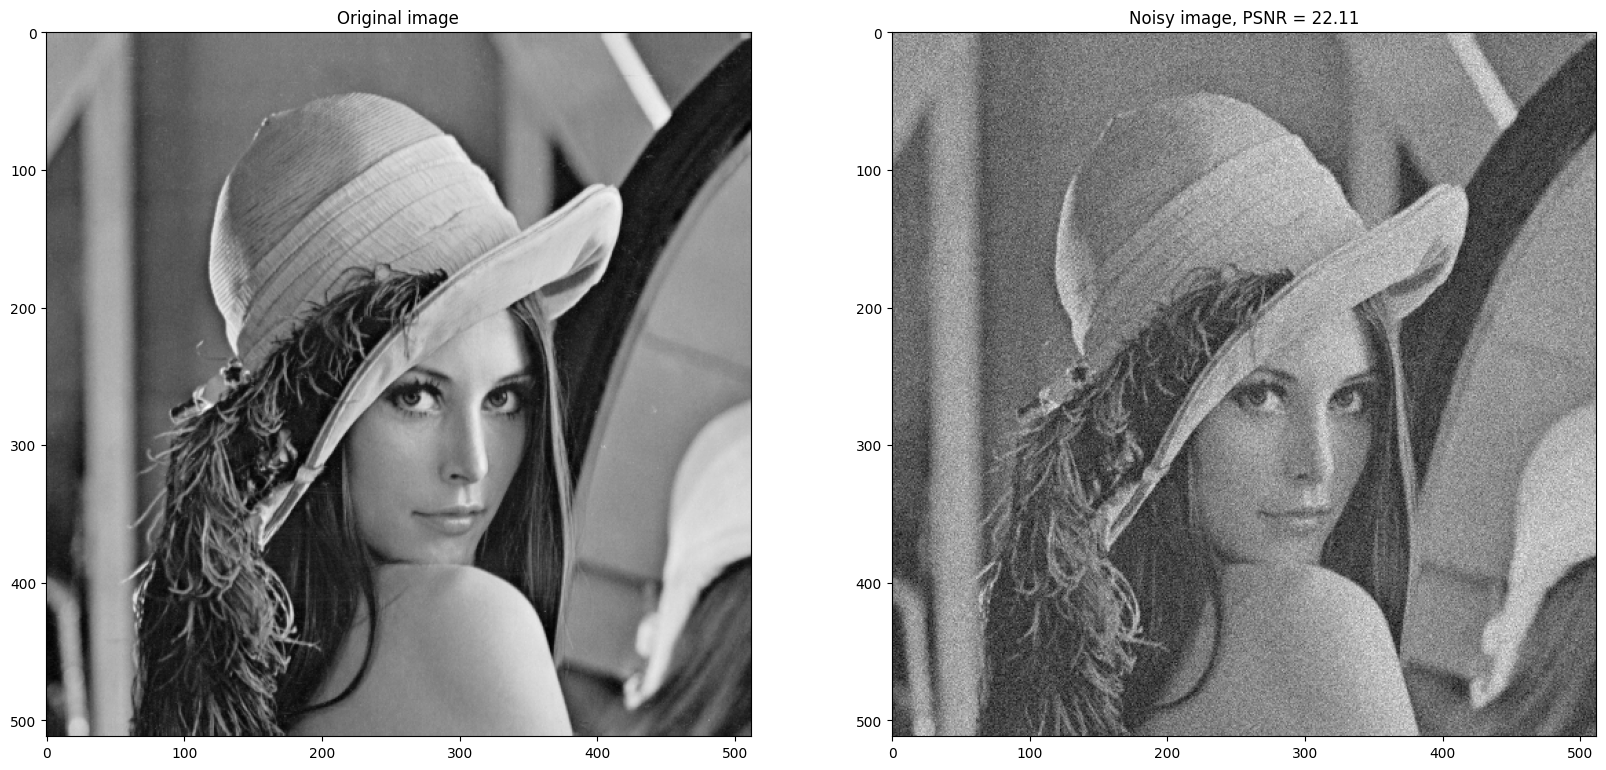

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original image')

ax[1].imshow(noisy_img, cmap='gray')
ax[1].set_title(f'Noisy image, PSNR = {psnr_noisy:.2f}')


Load and display the dictionary learned from patches

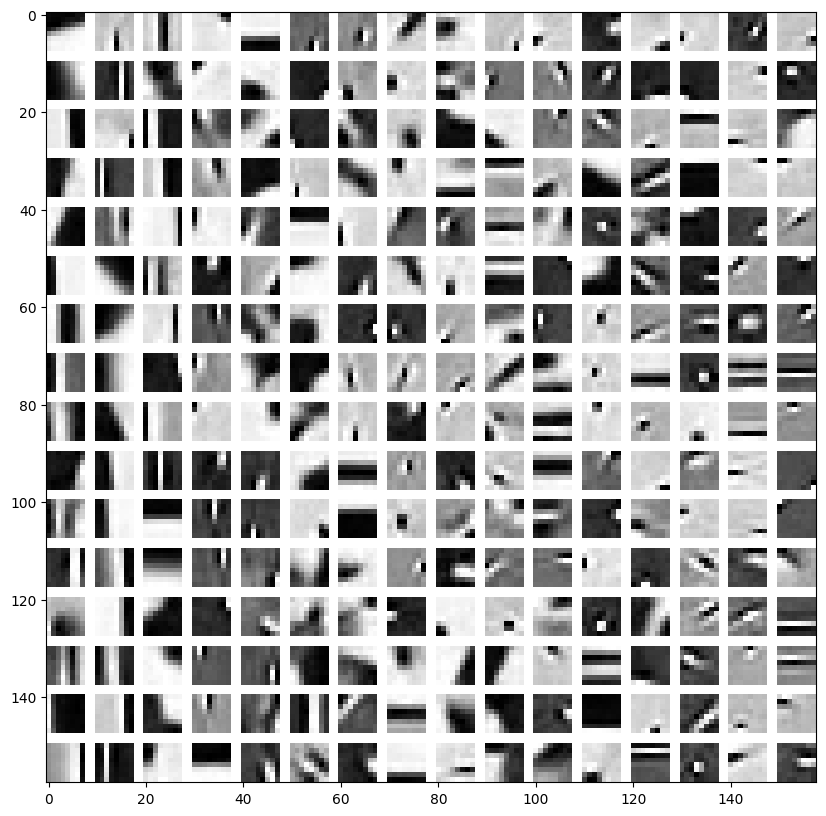

In [20]:
D = loadmat(f'{rootfolder}/data/dict_nat_img.mat')['D']

# display the dct basis
D_img = get_dictionary_img(D)
plt.figure(figsize=(10,10))
plt.imshow(D_img, cmap='gray')

Denoising
---------


In [21]:
# initialize the estimated image
img_hat = np.zeros_like(img)

# initialize the weight matrix
weights = np.zeros_like(img)

# set the threshold
tau = 1.15 * p * sigma_noise

# define the step (=p for non overlapping paches)
STEP = 4
# STEP = 1 might be very time consuming, start with larger STEP

Operate patchwise

In [22]:
for i in range(0, imsz[0] - p + 1, STEP):
  for j in range(0, imsz[1] - p + 1, STEP):
    # extrach the patch with the top left corner at pixel (ii, jj)
    s = noisy_img[i:i+p,j:j+p].flatten()

    # store and subtract the mean
    s_bar = s.mean()
    s = s - s_bar

    # perform the sparse coding
    x = OMP(s,D,M,tau)

    # perform the reconstruction
    s_hat = D@x

    # add back the mean
    s_hat = s_hat + s_bar
    s_hat = s_hat.reshape((p,p))

    # put the denoised patch into the estimated image using uniform weights
    w = 1
    #UPDATE img_hat
    img_hat[i:i+p,j:j+p] += s_hat * w

    # store the weight of the current patch in the weight matrix
    #UPDATE weights
    weights[i:i+p,j:j+p] += np.full((p,p),w)

Normalize the estimated image with the computed weights

In [23]:
img_hat = img_hat / weights

Compute the psnr of the estimated image

Text(0.5, 1.0, 'Estimated Image,\nPSNR = 31.01')

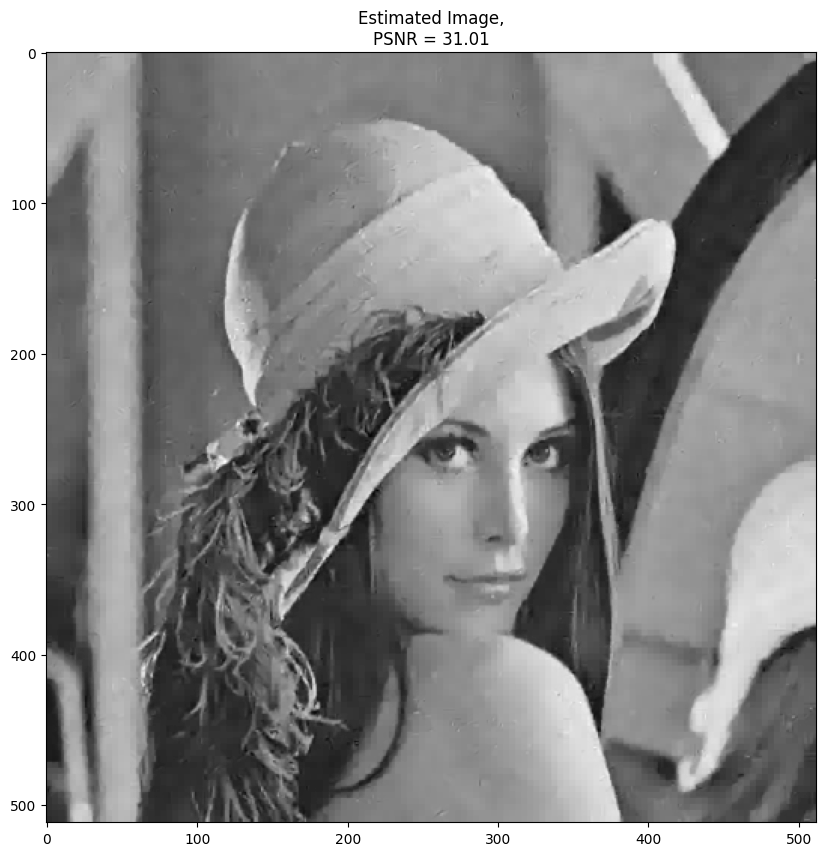

In [24]:
psnr_hat = 10*np.log10(1 / np.mean((img - img_hat) ** 2))
plt.figure(figsize=(10,10))
plt.imshow(img_hat, cmap='gray')
plt.title(f'Estimated Image,\nPSNR = {psnr_hat:.2f}')
